In [1]:
import os, time
from copy import deepcopy
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

# Pytorch
import torch
from tqdm import tqdm
use_cuda = False
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch, ArrowStyle
from style import colors
from fig_specs import *
from helpers import Arrow3D

from rnn_model_dt import RNN_Net
from task_generators import cycling as gen_task

Use cpu.


In [6]:
file_name = "cycling_n_256_train_rec_only.pkl"
data_file = os.path.join(data_path, file_name)

sce_plt = np.array([1, 0])
i_s_shows = [0, 0]
w_fac_aligned = 500
w_fac_oblique = 25

n_sce_plt = len(sce_plt)
i_sce_ob = sce_plt[0]

with open(data_file, 'rb') as handle:
    res = pickle.load(handle)
    [
        n_steps, n_samples, gs, out_scales, n_sce, opt_gens, lr0s, n_mi, dim_hid, dim_in, dim_out, 
        dt, rec_step_dt, n_layers, bias, train_in, train_hid, train_out, train_layers, nonlin, 
        gaussian_init, h_0_std, noise_input_std, noise_init_std, noise_hid_std, batch_size, 
        task_params, task_params_ev, n_t_ev, task_ev, n_if, n_ifn, steps, 
        loss_all, output_all, hids_all, h_0_all, sd_if_all, 
        n_rec_steps, rec_step_width, rec_steps, loss_avg_all, 
        w_in_norm_all, w_rec_norm_all, w_out_norm_all,
        dw_out_norm_all, dw_rec_norm_all, 
        h_proj_all, ps_all,
    ] = res
    del res
    print('Loaded from ', data_file)
    
lbl_sce = ["Oblique", "Aligned"] if n_sce == 2 else ["Oblique", "Oblique", "Aligned", "Aligned"]
t_dec = task_params["t_dec"]
freq = task_params["freq"]

Loaded from  ../data/cycling_n_256_train_rec_only.pkl


In [7]:
# Test task for plotting, or others

# Parameters
noise_input_std_ex = noise_input_std
noise_init_std_ex = noise_init_std
noise_hid_std_ex = noise_hid_std
assert noise_input_std_ex == 0.
assert noise_init_std_ex == 1.
assert noise_hid_std_ex == 0.2

t_max_ex = 150
task_params_ex = deepcopy(task_params)
task_params_ex["t_max"] = t_max_ex
# task_params_ex["test"] = True
ts_ex, input_ex, target_ex, mask_ex = gen_task(dim_in, dim_out, dt, **task_params_ex)(batch_size)
noise_input_ex = noise_input_std_ex * np.float32(np.random.randn(*input_ex.shape)) / np.sqrt(dt)
noise_init_ex = noise_init_std_ex * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
task_ex = ts_ex, input_ex, target_ex, mask_ex, noise_input_ex, noise_init_ex
ts_ex, input_ex, target_ex, mask_ex, noise_input_ex, noise_init_ex = [to_dev(arr) for arr in task_ex]
n_t_ex = len(ts_ex)
output_ex = np.zeros((*n_mi, batch_size, n_t_ex, dim_out), dtype=np.float32)
hids_ex = torch.zeros((*n_mi, batch_size, n_t_ex, dim_hid))
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    out_scale = out_scales[i_sce]
    g = gs[i_sce]
    # Network instance
    net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                  dt, rec_step_dt, train_layers)
    net.load_state_dict(sd_if_all[1][mi])
    h_0 = h_0_all[mi]
    # Transfer
    net.to(device)
    h_0 = h_0.to(device)
    with torch.no_grad():
        output, hids = net.forward_hid(input_ex + noise_input_ex, h_0 + noise_init_ex, noise_hid_std_ex)
        output_ex[mi] = output.cpu()
        hids_ex[mi] = hids.cpu()[0]

In [8]:
# Which hidden states to analyze?
plot_ev = False
if plot_ev:
    task_pl = task_ev
    i_if = 1
    hids_pl = hids_all[i_if]
    output_pl = output_all[i_if]
else:
    task_pl = task_ex
    hids_pl = hids_ex
    output_pl = output_ex
n_t_pl = hids_pl.shape[-2]

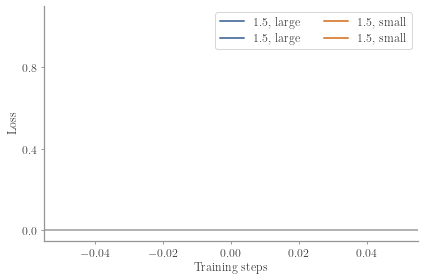

In [9]:
# Plot learning curves 
n_rows = 1
n_cols = 1
fig = plt.figure(figsize=(6, 4))
axes = subplots(fig, n_rows, n_cols)
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    c = colors[i_sce]
    ax = axes[0, 0]
    loss = loss_all[mi]
    lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce]) if i_s == 0 else None
    ax.plot(steps, loss, c=c, label=lbl, alpha=0.7)
    
    ax.plot(rec_steps, loss_avg_all[mi], c=c, label=lbl, alpha=0.7)
ax.axhline(0, c=c_leg, zorder=-1)
ax.legend(ncol=2)
ax.set_xlabel("Training steps")
ax.set_ylabel("Loss")
ax.set_ylim(-0.05, 1.1)
# ax.set_yscale('log')
fig.tight_layout()
style.fixticks(fig)

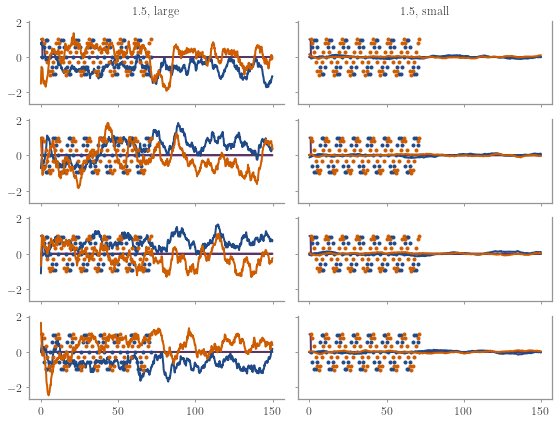

In [10]:
# Plot the task
n_show = min(batch_size, 4)

n_cols = n_sce
n_rows = n_show
fig = plt.figure(figsize=(4 * n_cols, 1.5 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)

# for mi in np.ndindex(*n_mi):
#     i_s, i_sce = mi
ts_pl, input_pl, target_pl, mask_pl, _, _ = task_pl
for i_sce in range(n_sce):
    i_s = 0
    mi = i_s, i_sce
    for i_b in range(n_show):
        ax = axes[i_b, i_sce]
        # Input
        for i_in in range(dim_in):
            ax.plot(ts_pl, input_pl[i_b, :, i_in], c=colors[4])
        for i_out in range(dim_out):
            c = colors[i_out]
            # Target
            m = mask_pl[i_b, :, i_out]
            ax.plot(ts_pl[m], target_pl[i_b, :, i_out][m], 'o', ms=3, c=c)
            # Output
            output = output_pl[mi]
            ax.plot(ts_pl, output[i_b, :, i_out], c=c)
    ax = axes[0, i_sce]
    lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce])
    ax.set_title(lbl)
fig.tight_layout()
style.fixticks(fig)

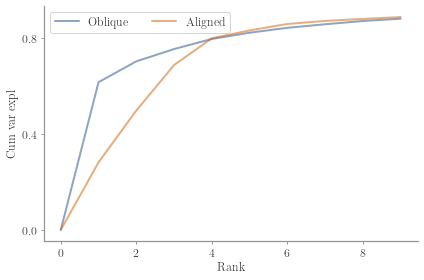

In [11]:
# PCA of hidden dynamics
n_comp = 9
n_trunc = n_comp + 1
ranks_trunc = np.arange(n_trunc)


# Min and max time for pca
t_pc_min = 10
n_t_pc_min = int(t_pc_min / (dt * rec_step_dt))
n_t_pc_max = n_t_pl
t_pc_max = n_t_pl * (dt * rec_step_dt)
n_t_pc = n_t_pc_max - n_t_pc_min

# Results arrays
h_proj_pl = np.zeros((*n_mi, batch_size, n_t_pl, n_comp))
cevr_pl = np.zeros((*n_mi, n_comp+1))
evr_pl = np.zeros((*n_mi, n_comp+1))
pcs_pl = torch.zeros((*n_mi, n_comp, dim_hid))
for mi in np.ndindex(*n_mi):
    h = hids_pl[mi][:, n_t_pc_min:n_t_pc_max].reshape(-1, dim_hid)
    pca = PCA(n_comp)
    pca.fit(h)
    ps = pca.components_
    h_proj_pl[mi] = hids_pl[mi] @ ps.T
    cevr_pl[mi][1:] = pca.explained_variance_ratio_.cumsum()
    evr_pl[mi][1:] = pca.explained_variance_ratio_
    pcs_pl[mi] = torch.from_numpy(np.float32(ps))

# Plot variance explained
n_rows = 1
n_cols = 1
fig = plt.figure(figsize=(6, 4))
axes = subplots(fig, n_rows, n_cols, sharex=True)
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    c = colors[i_sce]
    ax = axes[0, 0]
    lbl = lbl_sce[i_sce] if i_s == 0 else None
    ax.plot(ranks_trunc, cevr_pl[mi], c=c, alpha=0.5, label=lbl)
ax.set_ylabel("Cum var expl")
ax.legend(ncol=2)
ax.set_xlabel("Rank")
fig.tight_layout()
style.fixticks(fig)

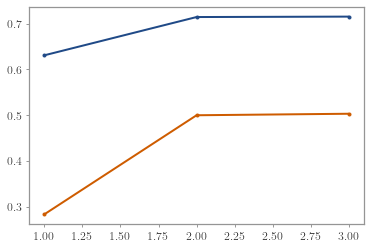

In [12]:
# First two PCs and projection on 1st output vector
n_comp_po = 3
h_proj_out_pl = np.zeros((*n_mi, batch_size, n_t_pl, n_comp_po))
wo_proj_out_pl = np.zeros((*n_mi, n_if, dim_out, n_comp_po))
cevr_out_pl = np.zeros((*n_mi, n_comp_po))

for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    
    # Compute projection axes: v_0, and the first 2 PCs of h_final outside v_0
    # 1. First 2 PCs.
    h = hids_pl[mi][:, n_t_pc_min:n_t_pc_max].reshape(-1, dim_hid)
    n_comp_pca = 2
    pca = PCA(n_comp_pca)
    pca.fit(h)
    # 2. Activity on the first output vector - 2 PCs
    w_out = sd_if_all[1, i_s, i_sce]["decoder.weight"][:1].numpy()
    pcs = np.linalg.qr(np.r_[pca.components_, w_out].T)[0].T
    # Fix signs
    for i_out in range(len(pcs)):
        if w_out[0] @ pcs[i_out] < 0:
            pcs[i_out] *= -1
    h_proj_out_pl[mi] = hids_pl[mi] @ pcs.T
    for i_if, i_out in np.ndindex(n_if, dim_out):
        wo_proj_out_pl[i_s, i_sce, i_if, i_out] = sd_if_all[i_if, i_s, i_sce]["decoder.weight"][i_out] @ pcs.T
    # Explained variance
    for i_c in range(n_comp_po):
        h_m = (h @ pcs[:i_c+1].T) @ pcs[:i_c+1]
        cevr_out_pl[mi][i_c] = h_m.var() / h.var()
        
# Plot cevr
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    ranks = np.arange(n_comp_po) +1
    plt.plot(ranks, cevr_out_pl[mi], 'o-', c=colors[i_sce])

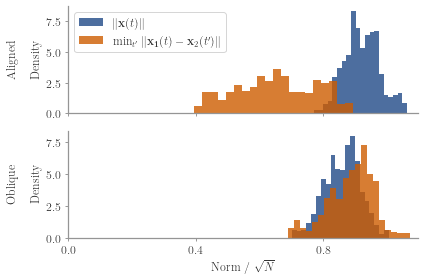

In [13]:
# Characterize distances between limit cycles
n_rows = 2
n_cols = 1
fig = plt.figure(figsize=(6, 4))
axes = subplots(fig, n_rows, n_cols, sharex=True)
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i_sce = sce_plt[i_r]
    mi = i_s, i_sce
    # Overall scale
    norm_h = torch.linalg.norm(hids_pl[mi][:2, n_t_pc_min:n_t_pc_max], axis=-1)
    # Distance between points in different attractors
    dh_bet = torch.linalg.norm(hids_pl[mi][0, n_t_pc_min:n_t_pc_max, None] - hids_pl[mi][1, None, n_t_pc_min:n_t_pc_max], axis=-1)
    # # Distance between points in the same attractor
    # dh_int = torch.linalg.norm(hids_pl[mi][:2, n_t_pc_min:n_t_pc_max, None] - hids_pl[mi][:2, None, n_t_pc_min:n_t_pc_max], axis=-1)
    # np.array([torch.min(norm_h), torch.max(norm_h), torch.max(dh_int), torch.min(dh_bet), torch.max(dh_bet)]) / np.sqrt(dim_hid)
    n_bins = 20
    ax.hist(norm_h.flatten() / np.sqrt(dim_hid), n_bins, density=True, color=colors[0], lw=0, alpha=0.8, label=r"$\|\mathbf{x}(t)\|$")
    ax.hist(torch.min(dh_bet, axis=-1)[0] / np.sqrt(dim_hid), n_bins, density=True, color=colors[1], lw=0, alpha=0.8, label=r"$\min_{t'} \|\mathbf{x_1}(t) - \mathbf{x}_2(t')\|$")
    # ax.hist(dh_bet.flatten(), n_bins, density=True, color=colors[1], lw=0, alpha=0.8, label=r"$\|\mathbf{x_1}(t) - \mathbf{x}_2(t')\|$")
    if i_r == 0:
        ax.legend(loc=2)
    ax.set_xlim(0, None)
    if i_r == n_rows -1:
        ax.set_xlabel(r"Norm / $\sqrt{N}$") 
    # else:
    #     ax.set_xticklabels([])
    lbl = lbl_sce[i_sce] + "\n\nDensity"
    ax.set_ylabel(lbl)
    
fig.tight_layout()
style.fixticks(fig)

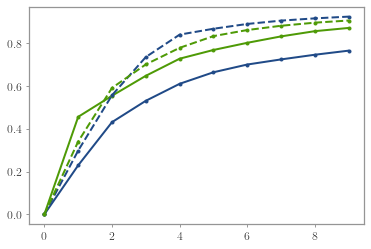

In [14]:
# Project the rotation of task 2 on task 1
n_sub = 2
cevr_sub_sce = np.zeros((*n_mi, n_sub, n_comp+1))
h_sub_proj_sce = np.zeros((*n_mi, n_sub, batch_size, n_t_pl, n_comp))
wo_sub_proj = np.zeros((*n_mi, n_sub, dim_out, n_comp))

# PCA of x
pca = PCA(n_comp)
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    h = hids_pl[mi][:, n_t_pc_min:n_t_pc_max]
    for i_b in range(n_sub):
        h_i = h[i_b]
        pca.fit(h_i)
        pcs = pca.components_.T
        cevr_sub_sce[mi][i_b, 1:] = pca.explained_variance_ratio_.cumsum()
        h_sub_proj_sce[mi][i_b] = hids_pl[mi] @ pcs
        wo_sub_proj[mi] = sd_if_all[1, i_s, i_sce]["decoder.weight"] @ pcs
    
# Plot cevr
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    ranks = np.arange(n_comp+1)
    m = ['o-', 'o--'][i_sce]
    for i_b in range(n_sub):
        c = colors[[0, 2][i_b]]
        plt.plot(ranks, cevr_sub_sce[mi][i_b], m, c=c)

In [15]:
# Frequencies for FFT
dt_rec = rec_step_dt * dt
freqs = np.fft.fftfreq(n_t_pc, dt_rec)
mf = freqs >= 0
freqs = freqs[mf]
n_f = len(freqs)
ps_pl = np.zeros((*n_mi, batch_size, n_f, n_comp))
for mi in np.ndindex(*n_mi):
    h_proj = h_proj_pl[mi][:, n_t_pc_min:n_t_pc_max]

    # Power spectra via FFT
    ps = np.abs(np.fft.fft(h_proj, axis=-2)[:, mf, :])**2
    ps_pl[mi] = ps
    
# Other global parameters for PSD
n_comp_show = 6
f_max_show = 0.45
mf_show = freqs <= f_max_show
n_f_max = (mf_show).sum()

# Colormap for plotting
cmap_psd = mpl.cm.YlGnBu_r
vmin_psd = 1.5 #np.log10(ps_pl).min()
vmax_psd = 6.5 #np.log10(ps_pl).max()

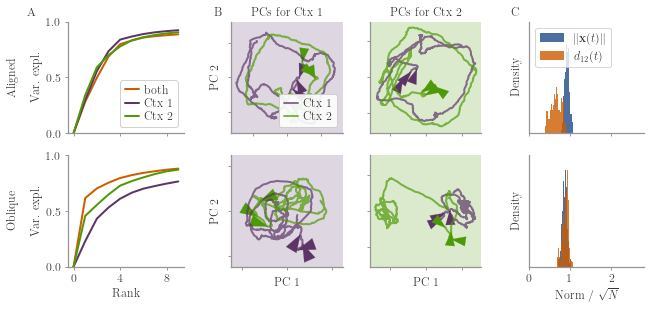

In [16]:
# Join plots
n_rows = n_sce
fig = plt.figure(figsize=(8, 3.4), facecolor='w')

n_cols_0 = 1
gs0 = GridSpec(n_rows, n_cols_0)
gs0.update(left=0., right=0.2, bottom=0.0, top=1., wspace=0., hspace=0.2)
axes_0 = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(n_cols_0)] for k in range(n_rows)])

n_cols_1 = 2
gs0 = GridSpec(n_rows, n_cols_1)
gs0.update(left=0.27, right=0.73, bottom=0.0, top=1., wspace=0.1, hspace=0.2)
axes_1 = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(n_cols_1)] for k in range(n_rows)])

n_cols_2 = 1
gs0 = GridSpec(n_rows, n_cols_2)
gs0.update(left=0.8, right=1., bottom=0.0, top=1., wspace=0., hspace=0.2)
axes_2 = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(n_cols_2)] for k in range(n_rows)])


################################################################################
# Cevr
axes = axes_0
n_cols = n_cols_0
ranks = np.arange(n_comp+1)
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i_sce = sce_plt[i_r]
    mi = i_s, i_sce
    ax.plot(ranks, cevr_pl[mi], c=colors[1], label="both")
    for i_b in range(n_sub):
        c = cs_ctx[i_b]
        lbl = "Ctx %d" % (i_b+1)
        ax.plot(ranks, cevr_sub_sce[mi][i_b], c=c, label=lbl)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.5, 1.])
    ax.set_xticks([0, 4, 8])
    if i_r == n_rows - 1:
        ax.set_xlabel("Rank")
    else:
        ax.set_xticklabels([])
    if i_c == 0:
        lbl = lbl_sce[i_sce] + "\n\nVar. expl."
        ax.set_ylabel(lbl)
    if i_r == 0:
        ax.legend(loc=4, ncol=1, 
                  labelspacing=0.2, handlelength=1.2, handletextpad=0.4, columnspacing=0.5,
                  framealpha=0.9, markerscale=0.5,
                  # bbox_to_anchor=(1.1, 1.05)
                 )
        
################################################################################
# PCs
axes = axes_1
n_cols = n_cols_1
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i_sce = sce_plt[i_r]
    mi = i_s, i_sce
    i_b = i_c
    for j_b in range(n_sub):
        c = cs_ctx[j_b]
        h_proj = h_sub_proj_sce[mi][i_b][j_b][:, :2]
        # ax.plot(*h_proj[:n_t_pc_min].T, '-', c=c, alpha=0.7)
        lbl = "Ctx %d" % (j_b+1)
        ax.plot(*h_proj[n_t_pc_min:].T, '-', c=c, alpha=0.7, label=lbl)
        # Plot directions
        xmax = np.abs(h_sub_proj_sce[mi][..., :2]).max()
        hw = 0.18 * xmax
        n_dir = 3
        for i_dir in range(n_dir):
            freq = 0.1
            t_step = int((1/freq) / n_dir / (dt * rec_step_dt))
            i_t = n_t_pc_min + t_step * i_dir
            x = h_proj[i_t:i_t+2, 0]
            y = h_proj[i_t:i_t+2, 1]
            ax.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], lw=0.2, shape='full',
               length_includes_head=True, head_width=hw, color=c, zorder=None)
    xmax = max([max(np.abs(lim)) for lim in (ax.get_xlim(), ax.get_ylim())])
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-xmax, xmax)
    ax.set_aspect("equal")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if i_r == 0:
        ax.set_title("PCs for Ctx %d" % (i_b+1))
    if i_r == n_rows - 1:
        ax.set_xlabel("PC 1")
    if i_c == 0:
        ax.set_ylabel("PC 2")
    if i_r == 0 and i_c == 0:
        ax.legend(loc=4, ncol=1, 
                  labelspacing=0.2, handlelength=1.2, handletextpad=0.4, columnspacing=0.5,
                  framealpha=0.9, markerscale=0.5,
                  # bbox_to_anchor=(1.1, 1.05)
                 )
        
    c = cs_ctx[i_b%2]
    ax.set_facecolor(c)
    ax.patch.set_alpha(0.2)
    
################################################################################
# Norms, distances
axes = axes_2
n_cols = n_cols_2
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i_sce = sce_plt[i_r]
    mi = i_s, i_sce
    # Overall scale
    norm_h = torch.linalg.norm(hids_pl[mi][:2, n_t_pc_min:n_t_pc_max], axis=-1)
    # Distance between points in different attractors
    dh_bet = torch.linalg.norm(hids_pl[mi][0, n_t_pc_min:n_t_pc_max, None] - hids_pl[mi][1, None, n_t_pc_min:n_t_pc_max], axis=-1)
    # # Distance between points in the same attractor
    # dh_int = torch.linalg.norm(hids_pl[mi][:2, n_t_pc_min:n_t_pc_max, None] - hids_pl[mi][:2, None, n_t_pc_min:n_t_pc_max], axis=-1)
    # np.array([torch.min(norm_h), torch.max(norm_h), torch.max(dh_int), torch.min(dh_bet), torch.max(dh_bet)]) / np.sqrt(dim_hid)
    n_bins = 20
    ax.hist(norm_h.flatten() / np.sqrt(dim_hid), n_bins, density=True, color=colors[0], lw=0, alpha=0.8, label=r"$\|\mathbf{x}(t)\|$")
    ax.hist(torch.min(dh_bet, axis=-1)[0] / np.sqrt(dim_hid), n_bins, density=True, color=colors[1], lw=0, alpha=0.8, 
            # label=r"$\min_{t'} \|\mathbf{x_1}(t) - \mathbf{x}_2(t')\|$")
            label=r"$d_{12}(t)$")
    # ax.hist(dh_bet.flatten(), n_bins, density=True, color=colors[1], lw=0, alpha=0.8, label=r"$\|\mathbf{x_1}(t) - \mathbf{x}_2(t')\|$")
    if i_r == 0:
        ax.legend(loc=2)
    ax.set_xlim(0, 2.8)
    if i_r == n_rows -1:
        ax.set_xlabel(r"Norm / $\sqrt{N}$") 
    else:
        ax.set_xticklabels([])
    ax.set_ylabel("Density")
    ax.set_yticks([])
    

    
style.fixticks(fig)

# Label plots
for i in range(3):
    ax = [axes_0, axes_1, axes_2][i][0, 0]
    xpos = [-0.32, -0.12, -0.12][i]
    ypos = 1.04
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
        
# Save figure
fig_name = "cycling_details"
# style.saving_fig(fig, figure_path, fig_name, data_type='both')

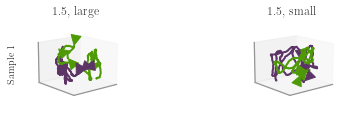

In [17]:
## Plot PCA
samples_plt = np.arange(n_samples)
n_rows = len(samples_plt)
# n_show = min(batch_size, 16)
b_show = np.arange(2)
n_show = len(b_show)
n_cols =  n_sce

# fig_width = 20
# fig_height = 4 * n_rows
fig_width = 6
fig_height = 1.2 * n_rows
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')
plot_3d = True
dim_p = 2 + plot_3d
# PCA
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.)
axes = np.array([[fig.add_subplot(gs0[k, j], projection='3d' if plot_3d else None)
                      for j in range(n_cols)] for k in range(n_rows)])

ts_pl, input_pl, target_pl, mask_pl, _, _ = task_pl
for i_r, i_bs, i_c in np.ndindex(n_rows, n_show, n_cols):
    ax = axes[i_r, i_c]
    i_s = samples_plt[i_r]
    i_sce = i_c
    mi = i_s, i_sce
    alpha = 1
    cs_if = cs[i_sce][[1, 0]]
    i_b = b_show[i_bs]
    
    # PCA
    i_if = 1
    h_proj = h_proj_pl[i_s, i_sce, i_b]
    input = input_pl[i_b]
    target = target_pl[i_b]
    mask = mask_pl[i_b]
    
    c = cs_ctx[i_b%2]
    # ax.plot(*h_proj[:n_t_pc_min, :dim_p].T, '--', c=c, alpha=alpha)
    ax.plot(*h_proj[n_t_pc_min:, :dim_p].T, '-', c=c, alpha=alpha)
    # Plot directions
    if i_b in b_show[:2]:
        n_dir = 3
        for i_dir in range(n_dir):
            freq = 0.1
            t_step = int((1/freq) / n_dir / (dt * rec_step_dt))
            i_t = n_t_pc_min + t_step * i_dir
            x = h_proj[i_t:i_t+2, 0]
            y = h_proj[i_t:i_t+2, 1]

            hw = 10
            if plot_3d:
                z = h_proj[i_t:i_t+2, 2]
                a = Arrow3D(x, y, z, mutation_scale=25, lw=1, arrowstyle="-|>", color=c)
                # a.set_zorder(10)
                ax.add_artist(a)
            else:
                ax.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], lw=0.2, shape='full',
                   length_includes_head=True, head_width=hw, color=c, zorder=10)

    if i_b == b_show[0]:
        if plot_3d:
            # Perspective
            ax.azim = 50
            # ax.dist = 8
            ax.elev = 14
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

        if i_s == 0:
            ax = axes[0, i_sce]
            lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce])
            ax.set_title(lbl)
        if i_sce == 0:
            ax = axes[i_s, 0]
            fig.text(-0.25, 0.5, "Sample %d" %(i_s+1), ha='center', va='center', rotation=90, 
                    transform=ax.transAxes)
        
        # if i_r == 0 and i_c == 0:
        #     ax.legend(ncol=2)
        
style.fixticks(fig)

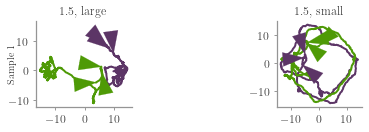

In [18]:
## Plot 2D PCA
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')
plot_3d = False
dim_p = 2 + plot_3d
# PCA
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1., bottom=0., top=1., wspace=0.2, hspace=0.)
axes = np.array([[fig.add_subplot(gs0[k, j], projection='3d' if plot_3d else None)
                      for j in range(n_cols)] for k in range(n_rows)])

ts_pl, input_pl, target_pl, mask_pl, _, _ = task_pl
for i_r, i_bs, i_c in np.ndindex(n_rows, n_show, n_cols):
    ax = axes[i_r, i_c]
    i_s = samples_plt[i_r]
    i_sce = i_c
    mi = i_s, i_sce
    alpha = 1.
    cs_if = cs[i_sce][[1, 0]]
    i_b = b_show[i_bs]
    
    # PCA
    i_if = 1
    h_proj = h_proj_pl[i_s, i_sce, i_b]
    input = input_pl[i_b]
    target = target_pl[i_b]
    mask = mask_pl[i_b]
    
    c = cs_ctx[i_b%2]
    # ax.plot(*h_proj[:n_t_pc_min, :dim_p].T, '--', c=c, alpha=alpha)
    ax.plot(*h_proj[n_t_pc_min:, :dim_p].T, '-', c=c, alpha=alpha)
    # Plot directions
    if i_b in b_show[:2]:
        n_dir = 3
        for i_dir in range(n_dir):
            freq = 0.1
            t_step = int((1/freq) / n_dir / (dt * rec_step_dt))
            i_t = n_t_pc_min + t_step * i_dir
            x = h_proj[i_t:i_t+2, 0]
            y = h_proj[i_t:i_t+2, 1]

            if plot_3d:
                z = h_proj[i_t:i_t+2, 2]
                a = Arrow3D(x, y, z, mutation_scale=25, lw=1, arrowstyle="-|>", color=c)
                a.set_zorder(10)
                ax.add_artist(a)
            else:
                ax.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], lw=0.2, shape='full',
                   length_includes_head=True, head_width=5, color=c, zorder=10)

    if i_b == b_show[0]:
        if plot_3d:
            # Perspective
            ax.azim = 50
            ax.dist = 8
            ax.elev = 14
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
        else:
            ax.set_aspect('equal')

        if i_s == 0:
            ax = axes[0, i_sce]
            lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce])
            ax.set_title(lbl)
        if i_sce == 0:
            ax = axes[i_s, 0]
            fig.text(-0.25, 0.5, "Sample %d" %(i_s+1), ha='center', va='center', rotation=90, 
                    transform=ax.transAxes)
        
        # if i_r == 0 and i_c == 0:
        #     ax.legend(ncol=2)
        
style.fixticks(fig)

### Cycling example plots

In [19]:
# Regress output from hidden states after PC

n_comp_max_fit = 30
n_comps_fit = np.arange(n_comp_max_fit)+1
n_nc = len(n_comps_fit)
# Subset of outputs used for training / testing
frac_train = 3/4
# Possible rgularization parameters
alpha_range = np.logspace(-3, 6, 20)

# Results
r_sq = np.zeros((*n_mi, n_nc))
r_sq_test = np.zeros((*n_mi, n_nc))
alphas = np.zeros((*n_mi, n_nc))
output_all = np.zeros(n_mi, dtype=object)
output_fit_all = np.zeros((*n_mi, n_nc), dtype=object)
cevr_fit = np.zeros((*n_mi, n_nc))

for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    out_scale = out_scales[i_sce]
    g = gs[i_sce]
    # Network instance
    net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                  dt, rec_step_dt, train_layers)
    net.load_state_dict(sd_if_all[1][mi])
    h_0 = h_0_all[mi]
    # Transfer
    net.to(device)
    h_0 = h_0.to(device)
    # Run noise-free dynamics
    with torch.no_grad():
        output, hids = net.forward_hid(input_ex + noise_input_ex, h_0 + noise_init_ex, noise_hid_std_ex)
        # output, hids = net.forward_hid(input_ex + 0., h_0 + 0, 0.)
        output = np.array(output)
        hids = np.array(hids[0])
    # hids = np.array(hids_pl[mi])
    # output = output_pl[mi]
    
    output_all[mi] = output

    # Run PCA
    pca = PCA(n_comp_max_fit)
    h = hids[:, n_t_pc_min:n_t_pc_max, :].reshape(-1, dim_hid)
    pca.fit(h)
    h_proj = pca.transform(hids.reshape(-1, dim_hid)).reshape(batch_size, -1, n_comp_max_fit)
    cevr_fit[mi] = pca.explained_variance_ratio_.cumsum()
    # Regression on the activity projected on the PCs
    bs_train = int(frac_train * batch_size)
    y_train = output[:bs_train].reshape(-1, dim_out)
    for i_nc, n_comp in enumerate(n_comps_fit):

        X_train = h_proj[:bs_train, :, :n_comp].reshape(-1, n_comp)
        ridge = RidgeCV(alphas=alpha_range).fit(X_train, y_train)
        # Output for the entire batch (separate train and test later)
        output_fit = ridge.predict(h_proj[:, :, :n_comp].reshape(-1, n_comp)).reshape(batch_size, -1, dim_out)
        # Compute quality of fit
        r_sq[mi][i_nc] = 1 - ((output - output_fit)**2).mean()  / ((output - output.mean((0, 1), keepdims=True))**2).mean()
        r_sq_test[mi][i_nc] = 1 - ((output - output_fit)[bs_train:]**2).mean()  / ((output - output.mean((0, 1), keepdims=True))[bs_train:]**2).mean()
        alphas[mi][i_nc] = ridge.alpha_
        output_fit_all[mi][i_nc] = output_fit


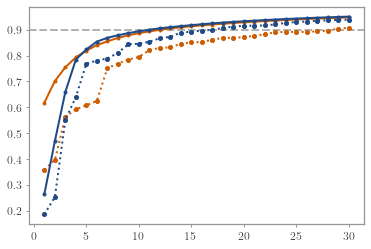

In [20]:
# Plot cevr vs R^2
fig, ax = plt.subplots()
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    ax.plot(n_comps_fit, cevr_fit[mi], 'o-', c=colors[[1, 0][i_sce]])
    ax.plot(n_comps_fit, r_sq[mi], 'o:', ms=4, c=colors[[1, 0][i_sce]])
    ax.axhline(0.9, ls='--', c=c_leg, zorder=-1)
    

R^2:  [[[0.39600525 0.76875153]
  [0.25251376 0.8102785 ]]]


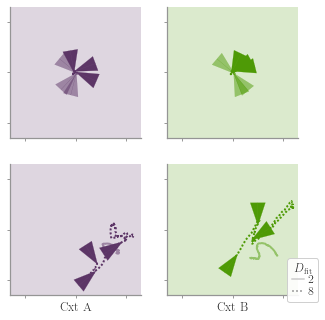

In [21]:
def plt_fit_example(axes, leg=False):
    n_rows, n_cols = axes.shape
    # Compare output of full and truncated 
    i_s = 0
    # i_nc = 6
    i_ncs = [1, 7]
    ls_nc = ['-', (0, (1, 1))]
    alpha_nc = [0.5, 1]
    print("R^2: ", r_sq[:, :, i_ncs])
    for i_r, i_c in np.ndindex(n_rows, n_cols):
        ax = axes[i_r, i_c]
        i_sce = sce_plt[i_r]
        mi = i_s, i_sce
        i_b = bs_train + i_c
        c = cs_ctx[i_b%2]
        # Output
        for i_ff in range(len(i_ncs)):
            i_nc = i_ncs[i_ff]
            # xys = output_all[mi][i_b]
            xys = output_fit_all[mi][i_nc][i_b]
            # xys = output_fit_all[mi][i_nc][i_b%2::2].mean(0)
            alpha = alpha_nc[i_ff]
            ls = ls_nc[i_ff]
            lbl = [
                "full",
                "fit",
            ][i_ff]
            # lbl = r"$R^2_{(%d)} = %.2f$" % (n_comps_fit[i_nc], r_sq[mi][i_nc])
            lbl = r"$%d: %.2f$" % (n_comps_fit[i_nc], r_sq[mi][i_nc])
            i_t0 = 2 * n_t_pc_min
            ax.plot(*xys[i_t0: i_t0+100].T, ls=ls, c=c, alpha=alpha)#, label=lbl)

            # Arrows
            # hw = 0.18
            hw = 0.3
            n_dir = 3
            if not (i_r == 1 and i_ff == 0):
                for i_dir in range(n_dir):
                    dt = 0.2
                    rec_step_dt = 1
                    freq = 0.1
                    t_step = int((1/freq) / n_dir / (dt * rec_step_dt))
                    # i_tp = np.array([[97, 112], [103, 113]])[i_r, i_c]
                    i_tp = 100
                    i_t = i_tp + t_step * i_dir
                    x, y = xys[i_t:i_t+2].T
                    ax.arrow(x[1], y[1], x[1]-x[0], y[1]-y[0], lw=0.2, shape='full',
                       length_includes_head=True, head_width=hw, color=c, alpha=alpha, zorder=None)

        # Facecolor indicating the scenario
        fc = cs_ctx[[i_b%2]]
        ax.set_facecolor(fc)
        ax.patch.set_alpha(0.2)
        # Legend
        # if i_r == 0 and i_c == 1:
        if i_c == 1 and i_r == 1 and leg:
            for i_ff in range(len(i_ncs)):
                i_nc = i_ncs[i_ff]
                ax.plot(0, 0, ls=ls_nc[i_ff], c=c_leg, alpha=alpha_nc[i_ff], 
                        label=r"$%d$" % (n_comps_fit[i_nc]))
            ax.legend(loc=4, ncol=1, 
                      # title= r"\#PCs: $R^2$", title_fontsize=fs,
                      # title= "Output", title_fontsize=fs,
                      title= "$D_\mathrm{fit}$", title_fontsize=fs,
                      labelspacing=0.08, handlelength=1., handletextpad=0.3, columnspacing=1.,
                      markerscale=1., framealpha=0.9, frameon=True,
                      bbox_to_anchor=(1.2, -0.1)
                     )
        ax.set_aspect("equal")
        xmax = 1.3
        ax.set_xlim(-xmax, xmax)
        ax.set_ylim(-xmax, xmax)
        ax.set_yticks(np.linspace(-1, 1, 3))
        ax.set_xticks(np.linspace(-1, 1, 3))
        if i_c == 0:
            i_wo = [1, 0][i_sce]
            lbl = ["Aligned", "Oblique"][i_wo]
            # lbl = ["small", "large"][i_wo] + r" $\mathbf{w}_\mathrm{out}$"
            # i_g = i_sce%2
            # lbl += ",\n" + "init. " + ["decaying", "chaotic"][i_g]
            # lbl += "\n" + "$z_2$"
            # ax.set_ylabel(lbl)
        # else:
        ax.set_yticklabels([])
        if i_r == n_rows-1:
            lbl = "Cxt " + "AB"[i_b%2]
            ax.set_xlabel(lbl, labelpad=0.2)
            # pass
            # ax.set_xlabel("$z_1$")
        # else:
        ax.set_xticklabels([])
        # if i_r == 0:
        #     lbl = "Cxt " + "AB"[i_b%2]
        #     ax.set_title(lbl)
    for ax in axes.flatten():
        style.fixticks(ax)

n_cols = 2
n_rows = 2
fig = plt.figure(figsize=(2 * n_cols, 2 * n_rows))
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1.0, bottom=0., top=1., wspace=0.2, hspace=0.2)
axes_ex = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(n_rows)])
plt_fit_example(axes_ex, leg=True)



4.1
R^2:  [[[0.39600525 0.76875153]
  [0.25251376 0.8102785 ]]]


/tmp/ipykernel_26304/2094738889.py:96: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8


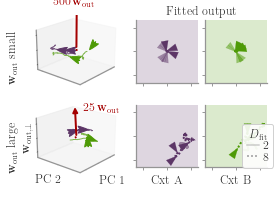

In [22]:
# Only PCs and fits
n_show = 2

# Time points for directional arrows
rel_its = np.array([
    [[0.2, 0.58], [0.19, 0.57]],
    [[0.7, 0.35], [0.23, 0.6]],
])
n_dir = rel_its.shape[-1]

# Choose colors
lss = ['--', '-']
alphas = [0.8, 0.7]
cs_hid = cs_ctx
# cs_hid = cs[0][[1, 0]] # Different shades of green
c_w = colors[3]

t_min_plt = t_pc_min
# t_max_plt = t_dec
t_max_plt = 41
n_t_min_plt = int(t_min_plt // (dt * rec_step_dt))
n_t_max_plt = int(t_max_plt // (dt * rec_step_dt))
t_cyc = 1 / freq
print(t_max_plt / t_cyc)

# Figure
n_rows = len(sce_plt)
n_cols = 1
fig = plt.figure(figsize=(3.3, 2.5), facecolor='w')
# PCA
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=0.29, bottom=0., top=1.1, wspace=0., hspace=-0.2)
axes_pca = np.array([[fig.add_subplot(gs0[k, j], projection='3d')
                  for j in range(n_cols)] for k in range(n_rows)])
# Power spectrum
n_rows = 2
n_cols = 2
gs0 = GridSpec(2, 2)
gs0.update(left=0.4, right=0.95, bottom=0.1, top=1., wspace=0.1, hspace=0.1)
axes_fit = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(n_rows)])

#######################################################################
# Plot PCA
i_pc = 0
plot_3d = True
dim_p = 2 + plot_3d
for i_r in range(n_rows):
    i_sce = sce_plt[i_r]
    ax = axes_pca[i_r, 0]
    i_s = i_s_shows[i_r]
    mi = i_s, i_sce
    for i_b in range(n_show):
        c = cs_hid[i_b]
        alpha = alphas[i_b]
        if i_pc == 0:
            h_proj = h_proj_out_pl[i_s, i_sce, i_b]
        else:
            h_proj = h_proj_pl[i_s, i_sce, i_b]
        lbl = "Ctx %s" % ("AB"[i_b]) 
        ax.plot(*h_proj[n_t_min_plt:n_t_max_plt, :dim_p].T, '-', lw=1, c=c, 
                alpha=alpha, label=None)

        # Plot directions
        # dti = int(t_step * rel_dtis[i_sce, i_b])
        for i_dir in range(n_dir):
            i_t = int(n_t_max_plt * rel_its[i_r, i_b, i_dir])
            dt_ar = [5, 2][i_sce]
            x = h_proj[[i_t,i_t+dt_ar], 0]
            y = h_proj[[i_t,i_t+dt_ar], 1]
            if plot_3d:
                z = h_proj[i_t:i_t+2, 2]
                arsty = ArrowStyle('Fancy', head_length=1, head_width=0.7, 
                                   tail_width=0.001)
                a = Arrow3D(x, y, z, mutation_scale=10, lw=1, arrowstyle=arsty, color=c)
                a.set_zorder(4)
                ax.add_artist(a)
            else:
                hw = [10, 14][i_r]
                ax.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], lw=0.2, shape='full',
                   length_includes_head=True, head_width=hw, color=c, zorder=4)

    # Axes 
    if i_pc == 0:
        xmax = np.abs(h_proj_out_pl[i_s, i_sce, :2, ..., :dim_p]).max() * 0.9
    elif i_pc == 1:
        xmax = np.abs(h_proj_pl[i_s, i_sce, :2, ..., :dim_p]).max() * 0.9
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-xmax, xmax)
    ax.set_zlim(-xmax, xmax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # Perspective
    ax.azim = 40
    ax.dist = 8
    ax.elev = 20
    if i_r == 1:
        ax.set_xlabel("PC 1", labelpad=-10)
        ax.set_ylabel("PC 2", labelpad=-12)
        ax.zaxis.set_rotate_label(False) 
        if i_pc == 0:
            ax.set_zlabel(r"$\mathbf{w}_{\mathrm{out}, \perp}$", labelpad=-17, rotation=90)
        else:
            ax.set_zlabel(r"PC 3", labelpad=-18, rotation=90)

    # Output vectors
    if i_pc == 0:
        for i_out in [0]:
            c = c_w
            wop = wo_proj_out_pl[i_s, i_sce, 1, i_out] 
            if out_scales[i_sce] == 'small':
                w_fac = w_fac_aligned
            else:
                w_fac = w_fac_oblique
            wop = wop * w_fac
            a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                        lw=2, arrowstyle="-|>", color=c)
            a.set_zorder(5)
            ax.add_artist(a)
            # Projection on 2d plane
            ax.plot([0, wop[0]], [0, wop[1]], [0, 0], ls=(0, (1, 1)), c=c, lw=2, alpha=1.)
            if w_fac != 1:
                y_pos = [wop[1]+5, wop[1]-15][i_sce]
                ax.text(wop[0], y_pos, wop[2] * 0.9, 
                        r"$%d\, \mathbf{w}_\mathrm{out}$" % w_fac, color=c, fontsize=fs)
            else:
                ax.text(wop[0], wop[1]+5, wop[2] * 0.8, 
                        r"$\mathbf{w}_\mathrm{out}$", color=c, fontsize=fs)
# Label
for i_r in range(n_rows):
    ax = axes_pca[i_r, 0]
    i_sce = sce_plt[i_r]
    lbl = r"$\mathbf{w}_\mathrm{out}$ " + ["large", "small"][i_sce]
    ypos = [0.75, 0.25][i_r]
    fig.text(-0.12, ypos, lbl, 
            fontsize=fs, ha='center', va='center', rotation=90)#, transform=ax.transAxes)
    
style.fixticks(fig, manage_ticks=False)
    
##################################################################################################
# Plot fits
plt_fit_example(axes_fit, leg=True)
ax = axes_fit[0, 0]
ax.text(1.05, 1.05, "Fitted output", ha='center', va='bottom', fontsize=fs, transform=ax.transAxes)

# Save figure
fig_name = "cycling_example_PC_fit"
# style.saving_fig(fig, figure_path, fig_name, data_type='both')